# Anomaly Detection - Algorithm Comparison

O presente notebook tem como intuito realizar a comparação dentre diferentes tipos de algorimtos de clusterização de dados. Os algoritmos utilizados serão:
  - K-Means
  - Dendograma (Clusterização hierárquica)

## Imports Necessários

In [125]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import seaborn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


## Dataset - NAB (Numenta Anomaly Detection)

O dataset mencionado acima, será utilizado para fazer um benchmark dentre modelos. Esse dataset já e bastante conhecido e utilizado para esses mesmos propósitos

### Extração do dataset em um **Data Frame**

Dentre os datasets disponiveis no NAB, o escolhido foi o de **machine_temperature_system_failure**

In [126]:
df = pd.read_csv('data/realKnownCause/machine_temperature_system_failure.csv')


Analisando o dataset, formatação e valores 

In [127]:
df.sample(5)


,timestamp,value
8973,2014-01-03 01:00:00,86.369797
2800,2013-12-12 14:35:00,94.370375
866,2013-12-05 21:25:00,64.225209
17776,2014-02-02 13:35:00,96.280916
1652,2013-12-08 14:55:00,73.251550


Realizando algumas mudanças para facilitar a análise gráfica do dataset

In [128]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] -32)*5/9


<AxesSubplot:xlabel='timestamp'>

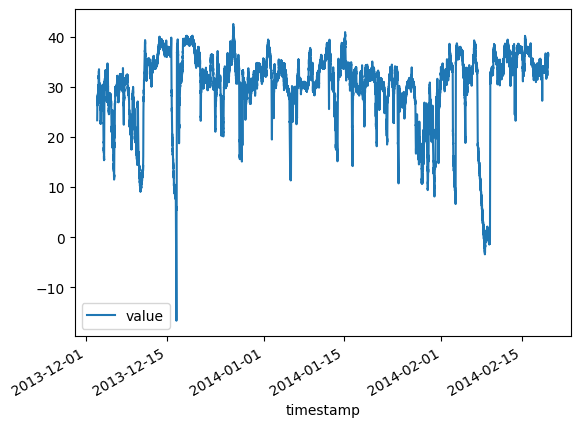

In [129]:
df.plot(x='timestamp',y='value')


Através da extração de alguns dados importantes do dataset, podemos criar novas colunas que irão facilitar na análise dos dados

In [131]:
df['hora'] = df['timestamp'].dt.hour #transformando o timestamp e arrendondado para as horas exatas dos dias
df['dia'] = ((df['hora'] >= 7) & (df['hora'] <= 22)).astype(int) # definindo se a medição foi tirada durante o dia ou a noite se for 1 é dia 0 noite
df['Dia_da_Semana'] = df['timestamp'].dt.dayofweek


### Normalização do dataset

Utilizaremos o StandardScaler devido a menor sensibilidade a outliers do que o MinMaxScaler

In [132]:
std_scaler = preprocessing.StandardScaler()


In [133]:
data_to_scale = df[['value','hora','Dia_da_Semana']]
data_to_scale = pd.DataFrame(std_scaler.fit_transform(data_to_scale))


In [134]:
# Utilizando PCA para selecionar as duas features mais importantes
pca = PCA(n_components=2)
data = pca.fit_transform(data_to_scale)

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)


In [135]:
df['main_feature1'] = data[0]
df['main_feature2'] = data[1]


Agora que os dados estão normalizados, o próximo passo será realizar um teste entre um número randômico de centroides, e através da análise pelo método do Cotovelo, poderemos checar qual o melhor valor de K.

### Primiero modelo a ser testado será o K-Means

In [74]:
n_centroids = range(1,30)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_centroids]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]


/home/joaocosentino/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joaocosentino/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joaocosentino/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/joaocosentino/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/clus

### Análise do numero de K centróides através do "Elbow Method"

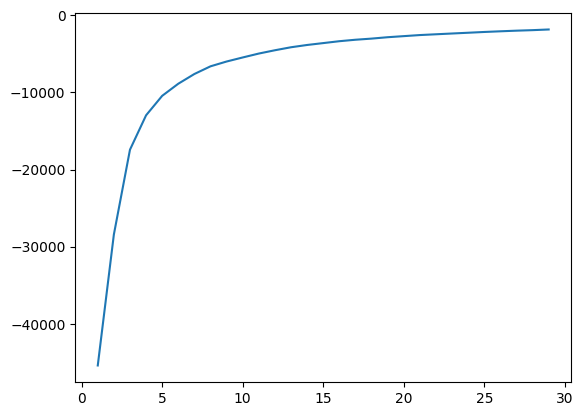

In [75]:
fig,ax = plt.subplots()
ax.plot(n_centroids,scores)
plt.show()


Como podemos ver no gráfico a partir de K=20 a diferença de score para o próximo K cai cada vez mais, por tanto utilizaremos K=20.

In [53]:
data_to_scale.drop(columns='predictions',inplace=True)


In [85]:
kmeans_20 = kmeans[19]
df['predictions'] = kmeans_20.predict(data)


Vamos plotar os diferentes clusters gerados a partir do treino do modelo com k=6, e para as 3 features envolvidas.

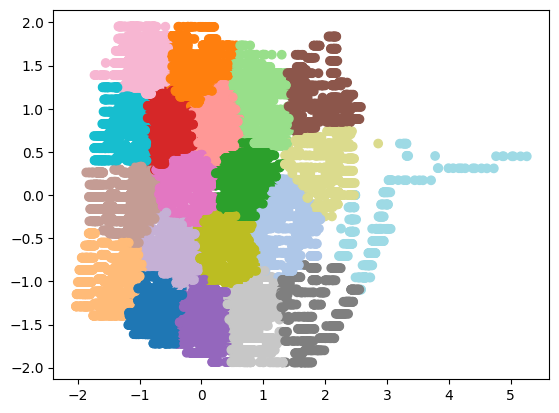

In [86]:
fig,ax = plt.subplots()
color_dict = {
    0: '#1f77b4',
    1: '#ff7f0e',
    2: '#2ca02c',
    3: '#d62728',
    4: '#9467bd',
    5: '#8c564b',
    6: '#e377c2',
    7: '#7f7f7f',
    8: '#bcbd22',
    9: '#17becf',
    10: '#aec7e8',
    11: '#ffbb78',
    12: '#98df8a',
    13: '#ff9896',
    14: '#c5b0d5',
    15: '#c49c94',
    16: '#f7b6d2',
    17: '#c7c7c7',
    18: '#dbdb8d',
    19: '#9edae5',
}
ax.scatter(df["main_feature1"],df['main_feature2'],c=df["predictions"].apply(lambda x: color_dict[x]))
plt.show()


De forma a identificar as anomalias vamos medir a distância de cada ponto e o seu centroide mais próximo.

### DBSCAN

O segundo modelo na comparação é o DBSCAN que utiliza a aglomeração por densidade.

In [183]:
db = DBSCAN(eps=0.05, min_samples=10).fit_predict(data)


In [154]:
outlier_mask = db == -1


In [184]:
unique_labels = set(db)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]


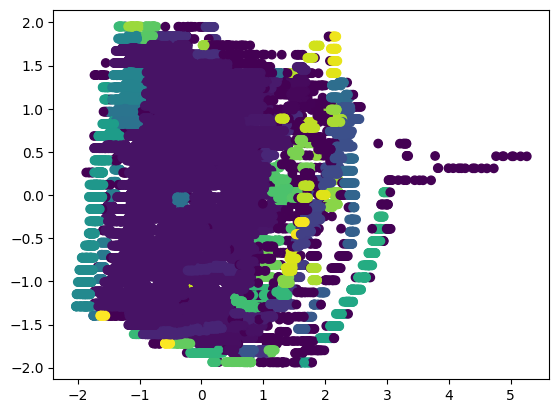

In [185]:
fig,ax = plt.subplots()
ax.scatter(df["main_feature1"],df['main_feature2'],c=db,cmap='viridis')
plt.show()


Com o DBSCAN a clusterização se tornou mais complexa devido a alta proximidadde entre os pontos, o modelo não consegue fazer a clusterização de forma correta. Mesmo com o ajuste do **eps** que é a medida de distância minima para dizer se dois pontos pertencem ao mesmo grupo, e também com o ajuste do **min_samples** que considera a quantidade minima que um ponto possui de vizinhos para considerá-lo ponto central, não foi possível obter um resutlado conclusivo.